In [1]:
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

# 1. Get Data

In [3]:
path = Path("/kaggle/input/ml4eo-crop-classification-challenge-slack")
trn_path = path/"train/train"
test_path = path/"test/test"
trn_path,test_path

(Path('/kaggle/input/ml4eo-crop-classification-challenge-slack/train/train'),
 Path('/kaggle/input/ml4eo-crop-classification-challenge-slack/test/test'))

In [4]:
# Load image Files
files = get_image_files(trn_path)

In [5]:
# Check sizes of images
sizes = [PILImage.create(o).size for o in files[:100]]
pd.Series(sizes).unique() 

array([(200, 200)], dtype=object)

It seems like all of our images are of same size (200,200)

# 2. Get Dataloaders

In [6]:
doc(aug_transforms)

aug_transforms(mult: 'float' = 1.0, do_flip: 'bool' = True, flip_vert: 'bool' = False, max_rotate: 'float' = 10.0, min_zoom: 'float' = 1.0, max_zoom: 'float' = 1.1, max_lighting: 'float' = 0.2, max_warp: 'float' = 0.2, p_affine: 'float' = 0.75, p_lighting: 'float' = 0.75, xtra_tfms: 'list' = None, size: 'int | tuple' = None, mode: 'str' = 'bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)
Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


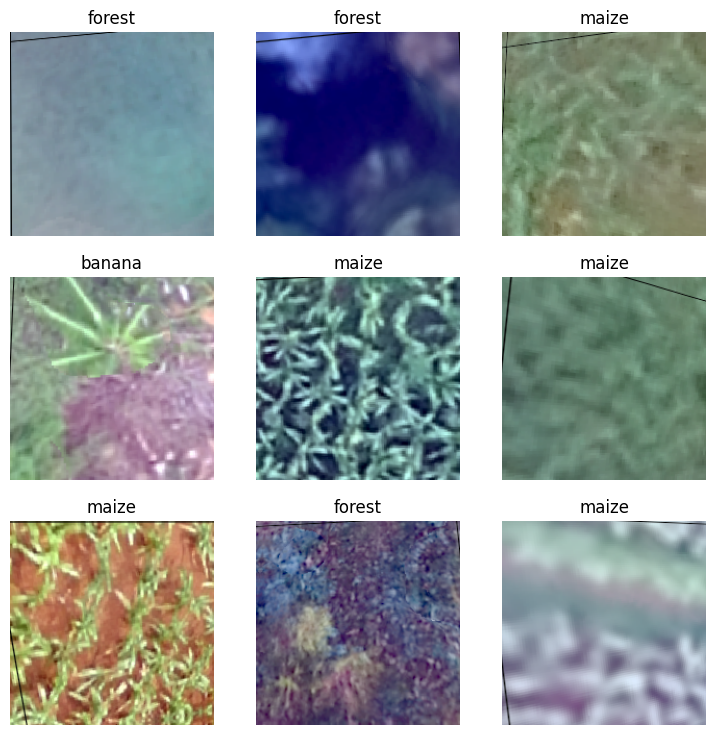

In [7]:
dls = ImageDataLoaders.from_folder(trn_path,valid_pct=0.2,batch_tfms=aug_transforms(min_scale=0.75))
dls.show_batch()

# 3. Get a pre-trained model

In [8]:
metric = F1Score(average="micro")

In [9]:
learn = vision_learner(dls,resnet34,metrics=[metric,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


In [10]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,1.423546,0.678015,0.775194,0.775194,00:13


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.720324,0.537837,0.817829,0.817829,00:12
1,0.557771,0.428297,0.855620,0.855620,00:12
2,0.433132,0.372703,0.873062,0.873062,00:12


In [11]:
test_files = get_image_files(test_path)
test_files.sort(key=lambda p:int(p.stem))

In [12]:
test_dl = dls.test_dl(test_files)

In [13]:
preds = learn.get_preds(dl=test_dl,with_decoded=True)

In [14]:
probs,_,idxs=preds

In [15]:
results_dict=dict(enumerate(idxs.numpy()))


In [16]:
results = pd.DataFrame(results_dict.items(),columns=["ID","Label"])
results.head()

,ID,Label
0,0,2
1,1,3
2,2,3
3,3,0
4,4,3


### Create a Mapping According to the guidelines for the label column

In [17]:
dls.vocab

['banana', 'forest', 'legumes', 'maize', 'other', 'structure']

In [18]:
mapping = {2:0,3:1,0:2,1:3,4:4,5:5}

In [19]:
results.Label=results['Label'].map(mapping)

In [20]:
results.to_csv('submission.csv',index=False)

In [21]:
!head submission.csv

ID,Label
0,0
1,1
2,1
3,2
4,1
5,0
6,1
7,1
8,3
